# Dust analyis 

What variables best explain observed year to year variability in SW dust concentrations and how do those varaibles change in the future as forecast by CMIP5 model output? 

The data shown in this notebook's figures are generated by **train_dist_concentration_classifier.ipynb**


In [1]:
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
from matplotlib import pyplot
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
import pandas as pd 
import geopandas as geo
import seaborn as sns
import os
import pickle
from matplotlib.patches import Patch # For making custom legends 
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import met_spread_utils as utils

In [2]:
# Chosen experiment
# Major change since last experiment ---
# no more winter predictors 
experiment = "v_2p0_50" #"v_1p0_50" 

In [3]:
dataDir = os.path.join('..', 'Data', 'Dust_Analysis', experiment)
print(dataDir)
geo_df_file = os.path.join(dataDir, 'results_geo_df')

../Data/Dust_Analysis/v_2p0_50


In [4]:
# Load the category names, rename as needed. 
with open(os.path.join(dataDir, "category_dictionary.obj"), 'rb') as fp:
    category_dictionary = pickle.load(fp)

all_vars   = category_dictionary['all'] 
plant_vars = category_dictionary['plant_vars'] 
atmos_vars = category_dictionary['atmos_vars'] 

print(all_vars)
print(plant_vars)
print(atmos_vars)

['mrlsl.integrated', 'hurs', 'lai', 'tas', 'VPD', 'pr', 'sfcWind']
['mrlsl.integrated', 'hurs', 'lai']
['tas', 'VPD', 'pr', 'sfcWind']


In [5]:
help(utils.make_nice_names)

Help on function make_nice_names in module met_spread_utils:

make_nice_names(bad_names)
    Some ugly code to clean up the feature names in this work. This function 
    takes an array or list of ugly cmip5 style variable names and spits out
    the names. E.g., "mrlsl.integrated" to "soil moisture".



In [6]:
# This list of ugly names is more comprehensive than needed now that this analysis does not include 
# any variables outside of the dust season. 
names = np.array([var+s for var in all_vars for s in ["_winter", "_spring", "_summer", "_dust_season"]  ])
print(names)

['mrlsl.integrated_winter' 'mrlsl.integrated_spring'
 'mrlsl.integrated_summer' 'mrlsl.integrated_dust_season' 'hurs_winter'
 'hurs_spring' 'hurs_summer' 'hurs_dust_season' 'lai_winter' 'lai_spring'
 'lai_summer' 'lai_dust_season' 'tas_winter' 'tas_spring' 'tas_summer'
 'tas_dust_season' 'VPD_winter' 'VPD_spring' 'VPD_summer'
 'VPD_dust_season' 'pr_winter' 'pr_spring' 'pr_summer' 'pr_dust_season'
 'sfcWind_winter' 'sfcWind_spring' 'sfcWind_summer' 'sfcWind_dust_season']


In [7]:
# Create a nice name dictionary from the lists of base feature names
nice_names = utils.make_nice_names(names)    
ndf = pd.DataFrame(index=names, data={"nice_name":nice_names})
ndf

,nice_name
mrlsl.integrated_winter,Soil Moisture (winter)
mrlsl.integrated_spring,Soil Moisture (spring)
mrlsl.integrated_summer,Soil Moisture (summer)
mrlsl.integrated_dust_season,Soil Moisture (dust season)
hurs_winter,RH% (winter)
hurs_spring,RH% (spring)
hurs_summer,RH% (summer)
hurs_dust_season,RH% (dust season)
lai_winter,LAI (winter)
lai_spring,LAI (spring)


In [8]:
usa = geo.read_file('../Data/GIS/cb_2017_us_state_500k')

### Setup consistent colors for divisions through paper 

Load the regression coeficient csv files. Remove do not include western US for now, this means now keeping the last row. 

In [9]:
# The :-1 indexing on the rows is to exclude "Western_US" region. 
lasso_all_coefs      = pd.read_csv(os.path.join(dataDir, 'lasso_all_coefs.csv'), index_col=0)
lasso_plant_coefs    = pd.read_csv(os.path.join(dataDir, 'lasso_plant_coefs.csv'), index_col=0)
lasso_atmos_coefs    = pd.read_csv(os.path.join(dataDir, 'lasso_atmos_coefs.csv'), index_col=0)
# We are not using combined coefs for this analysis, as the "separate analysis" are not actually separate. 
#lasso_combined_coefs = pd.read_csv(os.path.join(dataDir, 'lasso_combined_coefs.csv'), index_col=0).iloc[:-1,:]

In [10]:
lasso_all_coefs

,tas_dust_season,pr_dust_season,sfcWind_dust_season,hurs_dust_season,VPD_dust_season,mrlsl.integrated_dust_season,lai_dust_season
southwest,0,-0.13674,0.056718,-0.081425,0,-0.072036,0


Remove all columns where every coef is zero. Those are variables we do not need to plot. 

In [11]:
def rm_zero_column(df) :
    """Remove any column where the sum is zero."""
    df_ = df.iloc[:, np.array(df.sum() != 0)]
    # Set -0 to zero
    return df_.where(df_!=0, 0)

### Show the coefs for Lasso-all. 

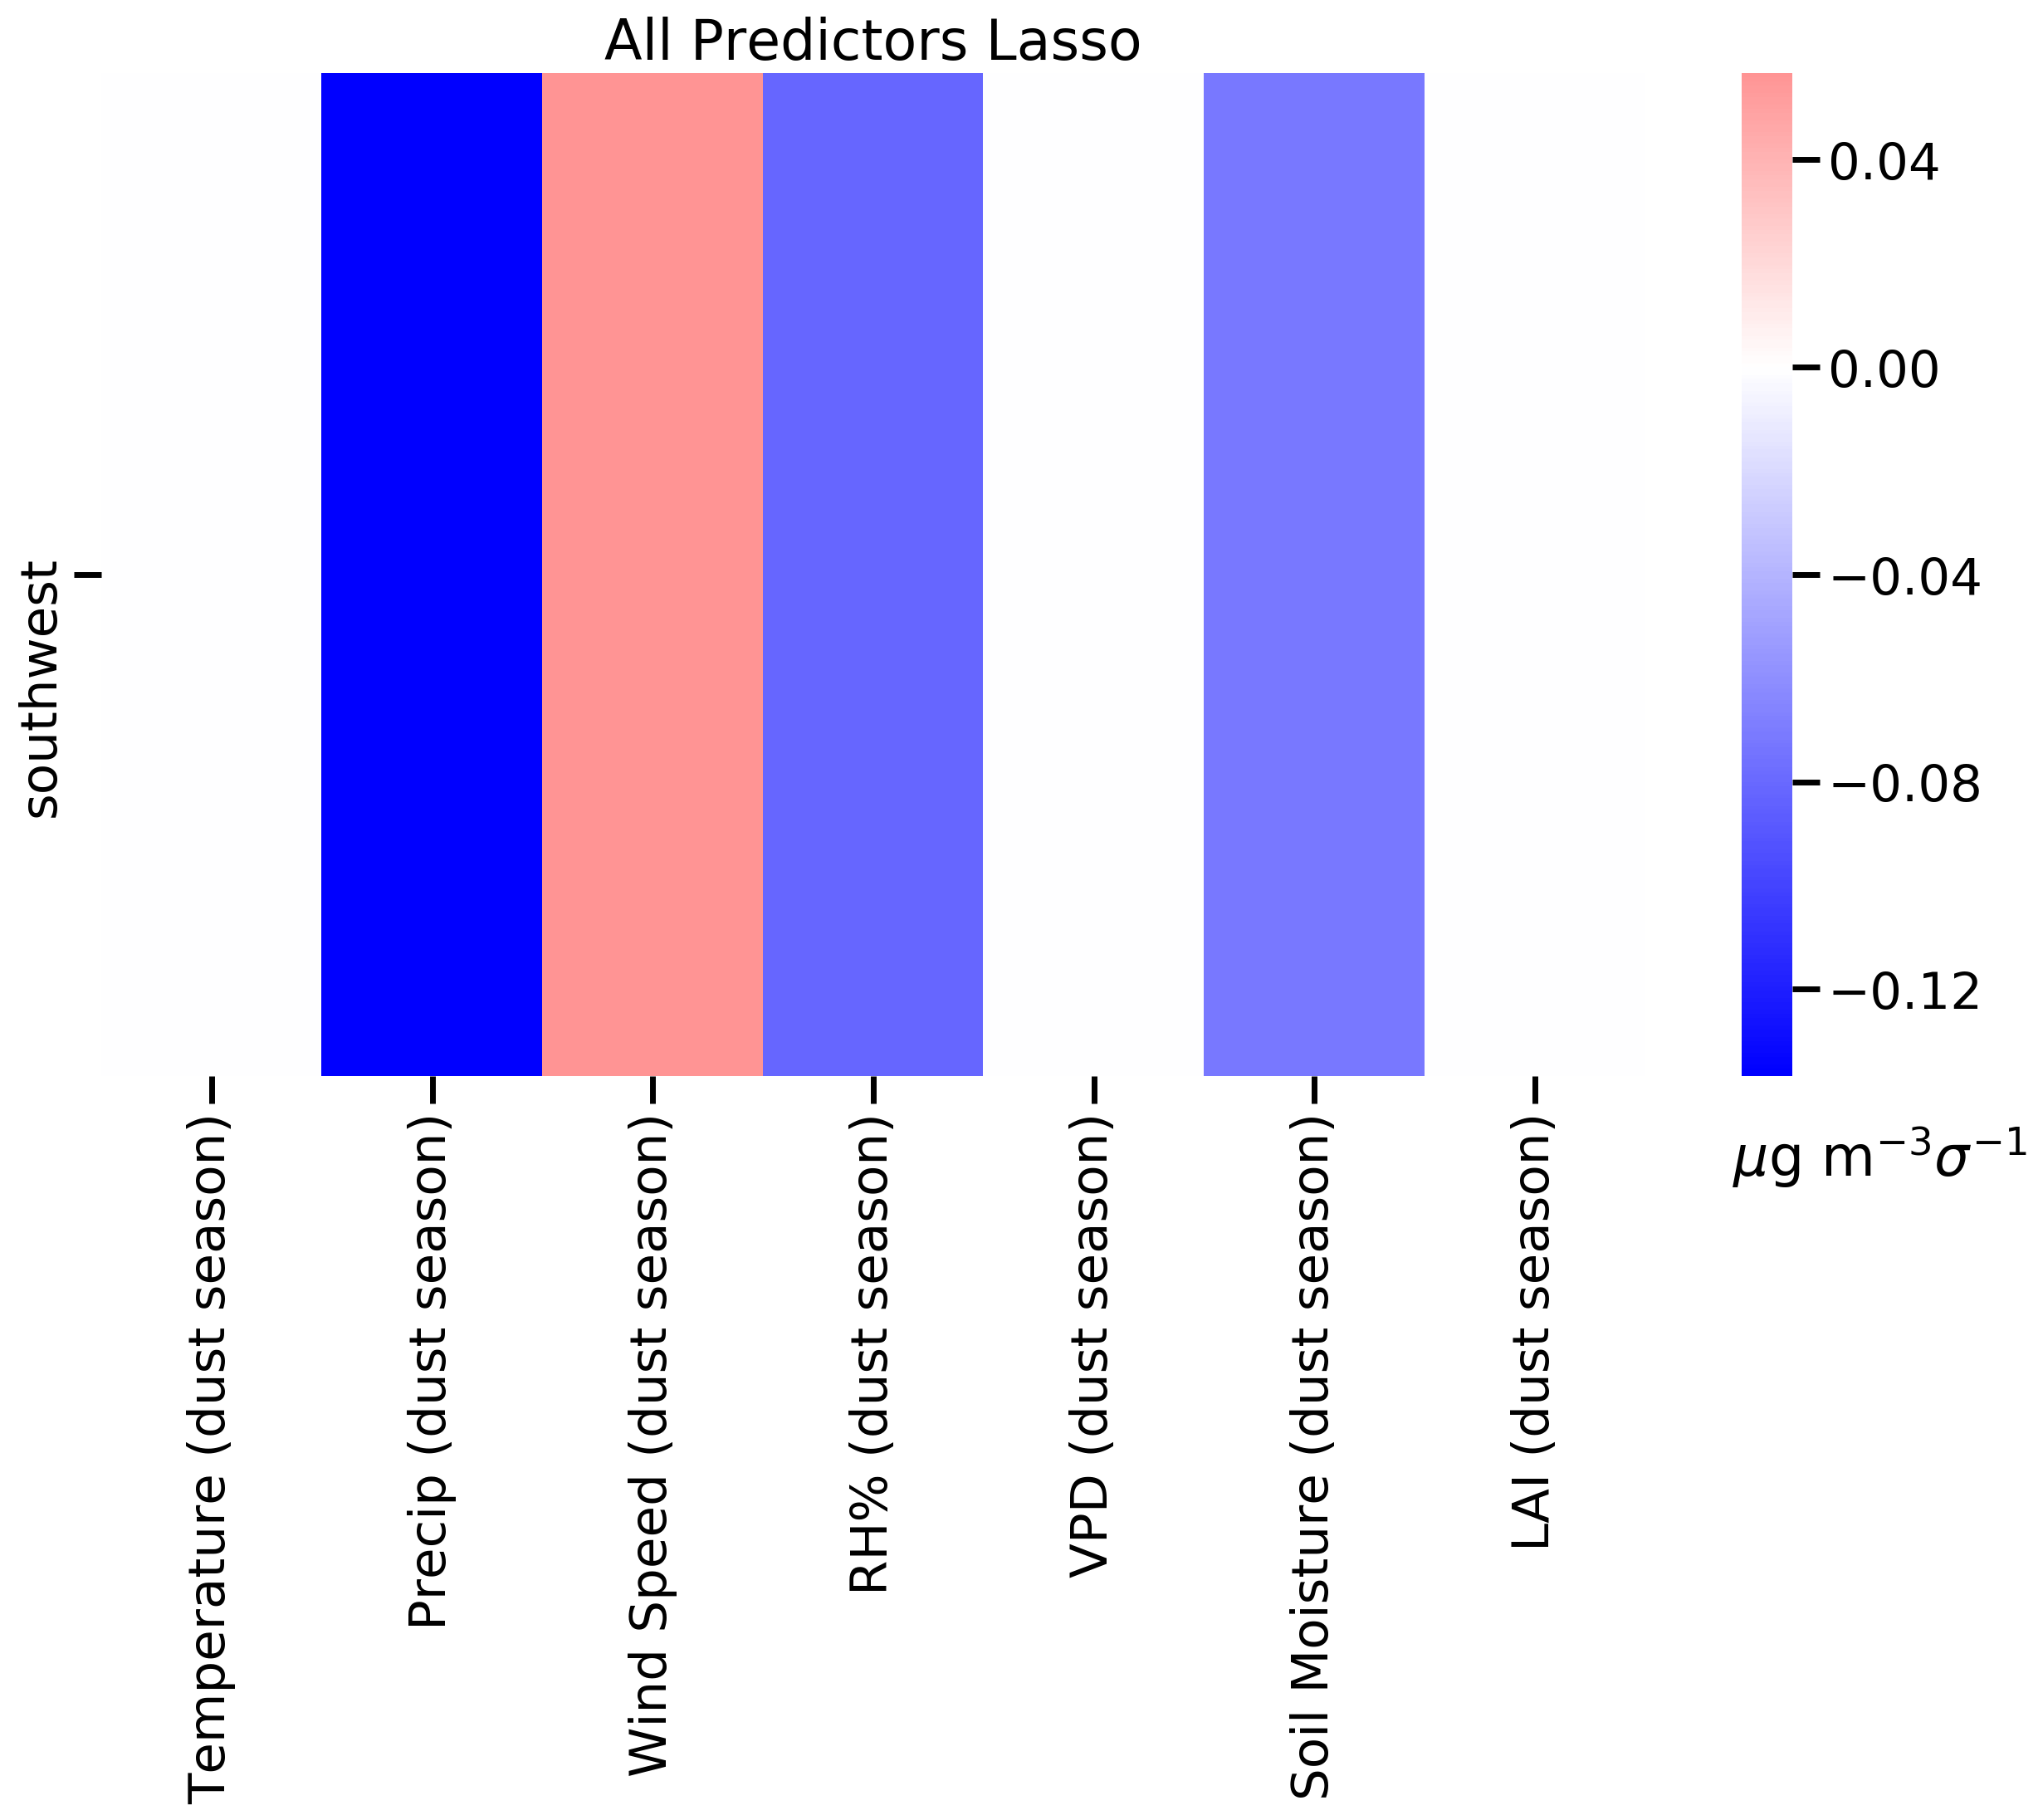

In [12]:
with sns.plotting_context("poster") :
    # TODO: Show r-squared on this plot 
    xticklabels = ndf.loc[lasso_all_coefs.columns.values, "nice_name"]
    
    f, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax1 = sns.heatmap(lasso_all_coefs, center=0, cmap="bwr", xticklabels=xticklabels)
    ax1.set(xlabel="", ylabel="", title="All Predictors Lasso")
    f.text(x=0.78, y=.05, s="$\mu$g m$^{-3}$$\sigma^{-1}$")
    plt.savefig(os.path.join(dataDir, "lasso_all_coefs_heat_matrix.png"), bbox_inches='tight')
    #plt.xticks(rotation=80)
    plt.show()

Is it more meaningful to show this in terms of -max:max scale for each ecoregion so that local importance and sign of relationship is what is shown? 
- Here is how to do that in case that makes more sense in the end

``````python
# normalize an array so the values range exactly between 0 and 1
Xmax, Xmin = X.max(), X.min()
S = (X - Xmin)/(Xmax - Xmin)

``````

Create a dataframe that contains the r-squared values for various linear models

As a sanity check only, the next figure should have highest performance for OLS, and more or less gradually decrease in skill. 

# Show predictor importance and variance for lasso all
- NOTE: lasso_combined_coefs does not have columns in the same order as Z_dict of era-interim, so make sure that you account for that when reading data in function below. 

In [13]:
def get_cmip5_Z_dict(regression_name, rcp) :
    """
    Function for loading pickled CMIP5 dictionaries. Returns 
    dictionary associated with the specified file name. 
    """
    print(dataDir)
    # Get the CMIP5 features expressed in terms of historical variance "Z_dict"
    # or thier raw values averaged in a region ""
    f = regression_name + "_Z_cmip_" + rcp + '_dict.obj'
    print("Getting " + f)
    with open(os.path.join(dataDir, f), 'rb') as fp:
        Z_cmip_dict = pickle.load(fp)
    return Z_cmip_dict 

#### Setup a color dictionary for consistent colors for predictors, show some colobar options 

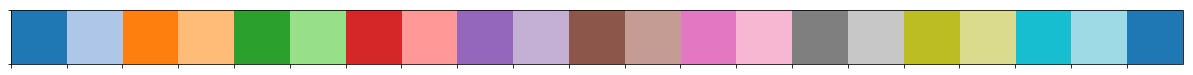

In [14]:
sns.palplot(sns.color_palette("tab20", n_colors=21))

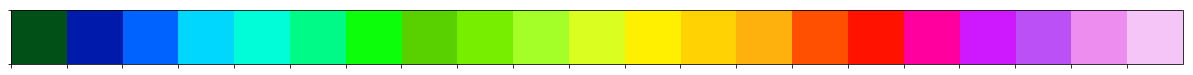

In [15]:
sns.palplot(sns.color_palette("gist_ncar", 21, 1))

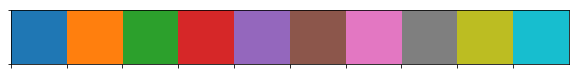

In [16]:
sns.palplot(sns.color_palette("tab10"))

### Make a custom legend and color scheme
# TODO: load whatever colors were used for features in the train_dust_concentration_classifier.ipynb

In [17]:
ndf = pd.read_csv(os.path.join(dataDir, "ndf.csv"), index_col=0)

In [18]:
# Make the colors associated with features in ndf a dictionary which
# is an easy way to assign colors for seaborn plots 
color_dict = {}
for i in ndf.index.values :
    l =(ndf.loc[i,"color"].replace("(","").replace(")","").split(","))
    ndf.loc[i, "color"] = tuple([float(j) for j in l])
    color_dict[i] = ndf.loc[i, "color"]

#### Create a custom legend 
- For consistent colors for a given feature 
- Consistent shape for feature type (plant, atmos)

In [19]:
feature_legend = [] # empty list to be appended

# Loop through features with non-zero coefs
for feature in lasso_all_coefs.columns.values[(lasso_all_coefs != 0).loc["southwest",:].values] : 

    fc = color_dict[feature]
    label_name = ndf.loc[feature, "nice_name"]

    # Set feature attributes to Line2D
    line_feature = Line2D([0], [0], marker="o", color='w', label=label_name, markerfacecolor=fc, markersize=15)
    
    # Store in list 
    feature_legend.append(line_feature)

In [20]:
def create_scatter_df(div, coef_df, div_Z_dict, y1=2070, y2=2099) :  
    """
    This creates a dataframe that makes for easy plotting and handling of differences
    in feature values from the training period 1984-2016 to years y1:y2. By the definition
    of how we standardize CMIP5 data for, the mean value for all CMIP model feature values
    for 1984-2016 the same as ERA-Interim, thus the difference is zero. The dataframe created
    
    Parameters
    ----------
        div : str, the division (ecoregion) for which a scatter_df will be created. 
        coef_df : pd.DataFrame, of lasso regression coeficients with shape =(n_division, n_features) 
        div_Z_dict : {}, containing different divisions dictionary of CMIP5 model Z (standardized)
                     output for estimating the change. 
        y1 : int, first year of the time period to average. 
        y2 : int, last year of the time period to average. 
        
    """
        
    # Get the division coeficients, only where non-zero, for this division. 
    df = coef_df.loc[div, coef_df.loc[div] != 0 ].copy()

    # Set up the DataFrame to hold information for scatterploting for div
    col_names = ["division", "feature", "feature_N", "feature_type", "coef", 
                 "CMIP5_mean", "CMIP5_std","CMIP5_min", "CMIP5_max"]
    
    df_scatter = pd.DataFrame(index=df.index, columns=col_names)
    df_scatter["division"]  = div
    df_scatter["feature_N"] = len(div_Z_dict.keys()) # models with all features for division 
    df_scatter["feature"]   = df_scatter.index.values.copy()
    df_scatter["coef"]      = df.values.copy()

    for model in div_Z_dict.keys() : 

        # Assign CMIP5 stats where they belong here. 
        Z_cmip = div_Z_dict[model]

        # We want the values for the last 30 years of 21st century
        # TODO: make time period a variable 
        future_mean_sigma = Z_cmip.loc[y1:y2, :].mean() # mean of columns, here variables 

        # Get the future sigma for the variables with non-zero coefs 
        # Add the new column for the data from THIS model 
        df_scatter[model] = future_mean_sigma[df_scatter.index]
            
    # Get the stats on the rows from the model sigma output. This gives the
    # mean of the changes calculated in the for loop above. 
    model_columns = list(div_Z_dict.keys())
    df_scatter.loc[:, "CMIP5_mean"] = df_scatter[model_columns].mean(axis=1).copy()
    df_scatter.loc[:, "CMIP5_std"] = df_scatter[model_columns].std(axis=1).copy()
    df_scatter.loc[:, "CMIP5_min"] = df_scatter[model_columns].min(axis=1).copy()
    df_scatter.loc[:, "CMIP5_max"] = df_scatter[model_columns].max(axis=1).copy()
    
    # Assign feature types
    # TODO: Pass these in
    
    for i in df_scatter["feature"] : 
        #print(i)
        s = pd.Series(i.split("_")[0]).isin(plant_vars).values
        #print(s)
        if  s : 
            df_scatter.loc[i, "feature_type"] = "Plant-Centric"
        else :
            df_scatter.loc[i, "feature_type"] = "Atmos-Centric"
            
    return df_scatter 

TODO: Remake this figure, capable of showing RCP 4.5 and 8.5 together

In [21]:
def plot_coef_vs_std(div, dataDir, regression_name, df, return_fig=False, rcp="8.5", color_dict='none', y1=2070, y2=2099) :  

    """
    Function for plotting a given divisions scatter_df (df), created by 
    the create_scatter_df() method. 
    
    Parameters
    ----------
        div : str, the name of the div being plotted, used for labelling only, as 
              df passed to function is already for a single division. 
        dataDir : Where the save the figure, if applicable. 
        reegression_name : str, the descriptive name of the type of regression associated
                           with how the data in df are stored. Example, plant- or -atmospheric
                           centric lasso regressions. 
        df : pd.DataFrame, this DataFrame was created by create_scatter_df() and 
             contains info about regression coef, how the coef variables change with CMIP5
             and the spread about those changes across available models. All for a specific
             rcp, division, regression. 
        return_fig : bool, when False a figure is created and saved. When True,
                     a figure object is return, and no figure is saved. This option
                     is desirable when a given div is being combined to a multipanel
                     plot with other divs using this function.
        rcp : str, used for labelling and figure savename only, as df is already associated
              with a specif rcp. 
    
    """
    # All sorts of string manipulation to make a decent
    # savename. 
    figure_savename = os.path.join(dataDir, "coef_scatter_plots" , regression_name + "_" + div.replace("/", " ") + "_coefs_vs_rcp"+rcp.replace(".","")+"_std.png")
    title_text = "RCP" +rcp +" CMIP5 $\mu_{"+str(y1)+"-"+str(y2)+"}$ - ERA-Interim $\mu_{1984-2016}$"    
    
    marker_dictionary = {"Plant-Centric":"o",
                         "Atmos-Centric":"s"
                        }
    
    if issubclass(type(color_dict), str) : 
        # No dictionar of colors passed, use defualt cmap
        pal = sns.color_palette("gist_ncar", df.shape[0], 1)
    else : 
        pal = color_dict
    
    ############################
    # Data ready, begin plotting 
    ############################
    if not return_fig :
        fig = plt.figure(dpi=250, figsize=(4, 4))
            
    ax = sns.scatterplot(x="coef", y="CMIP5_mean", hue="feature", data=df, 
                         #style="feature_type", 
                         #markers=marker_dictionary, 
                         s=70,
                         palette=pal, edgecolors="k", zorder=4)

    ax.axhline(y=0, color="k", linestyle="--", linewidth=0.8)
    ax.axvline(x=0, color="k", linestyle="--", linewidth=0.8)
    
    ax.set_xlabel('Coefficient [log$_{10}$(Burn Area) $\sigma^{-1}$]', fontsize=14)
    ax.set_ylabel('$\Delta$  [ERA-Interim $\sigma$$_{1988-2015}$]', fontsize=14)
    
    if not return_fig :
        ax.legend( bbox_to_anchor=(1,1.), title="", frameon=False)
        plt.title(label=title_text, fontsize=9)
        plt.suptitle(div)
    else :
        plt.title(label="RCP " + rcp, fontsize=15)
        # remove spines for neat plots. 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
    
    # Calculate the error (spread extent) bars for each variable
    error = np.zeros(shape=(2, len(df['CMIP5_min'])))
    lower_ext = df["CMIP5_mean"] - df['CMIP5_min']  # how far below 
    upper_ext = df['CMIP5_max'] - df["CMIP5_mean"]  # how far above 
    error[0][:] = np.array(lower_ext)
    error[1][:] = np.array(upper_ext)
    
    ax.errorbar(df["coef"], df["CMIP5_mean"], fmt=' ', 
                yerr=error, capsize=2, linewidth=0.8, 
                color="k", zorder=2)
    
    if not return_fig : 
        plt.savefig(figure_savename, bbox_inches='tight')
        plt.close()
    else :
        return ax

### plot_coef_vs_std() for regressions

In [22]:
# RCP8.5
lasso_all_Z_cmip85_dict   = get_cmip5_Z_dict(regression_name='lasso_all', rcp='85')
#lasso_plant_Z_cmip85_dict = get_cmip5_Z_dict(regression_name='lasso_plant', rcp='85')
#lasso_atmos_Z_cmip85_dict = get_cmip5_Z_dict(regression_name='lasso_atmos', rcp='85')

# RCP4.5
lasso_all_Z_cmip45_dict   = get_cmip5_Z_dict(regression_name='lasso_all', rcp='45')
#lasso_plant_Z_cmip45_dict = get_cmip5_Z_dict(regression_name='lasso_plant', rcp='45')
#lasso_atmos_Z_cmip45_dict = get_cmip5_Z_dict(regression_name='lasso_atmos', rcp='45')

../Data/Dust_Analysis/v_2p0_50
Getting lasso_all_Z_cmip_85_dict.obj
../Data/Dust_Analysis/v_2p0_50
Getting lasso_all_Z_cmip_45_dict.obj


Create the scatterplots from the individual experiments

In [23]:
lasso_all_Z_cmip85_dict['southwest'].keys()

dict_keys(['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'inmcm4'])

In [24]:
scatter_dir = os.path.join(dataDir, "coef_scatter_plots")
if not os.path.isdir(scatter_dir) :
    print("make a dir")
    os.mkdir(scatter_dir)

In [25]:
# Dictionaries to store scatter dfs for divisions 
scatter_df_85_dict = {}
scatter_df_45_dict = {}

for div in lasso_all_coefs.index.values : 
    
    print(div)
    # RCP 8.5 -------
    #                                 div, coef_df, div_Z_dict, y1=2070, y2=2099
    df_scatter_85 = create_scatter_df(div, lasso_all_coefs, lasso_all_Z_cmip85_dict[div])
    # Plot it 
    plot_coef_vs_std(div, dataDir, "lasso_all", df_scatter_85, return_fig=False, rcp="8.5", color_dict=color_dict)
    # Store the data associated with the plot 
    scatter_df_85_dict[div] = df_scatter_85
    
    # RCP 4.5 ------
    df_scatter_45 = create_scatter_df(div, lasso_all_coefs, lasso_all_Z_cmip45_dict[div])
    # Plot it 
    plot_coef_vs_std(div,  dataDir, "lasso_all", df_scatter_45, False, "4.5", color_dict) 
    # Save plotted data 
    scatter_df_45_dict[div] = df_scatter_45    


southwest


In [26]:
scatter_df_85_dict["southwest"].head()

,division,feature,feature_N,feature_type,coef,CMIP5_mean,CMIP5_std,CMIP5_min,CMIP5_max,ACCESS1-0,...,GFDL-ESM2G,GFDL-ESM2M,GISS-E2-H,GISS-E2-H-CC,GISS-E2-R,GISS-E2-R-CC,MIROC-ESM,MIROC-ESM-CHEM,MIROC5,inmcm4
pr_dust_season,southwest,pr_dust_season,15,Atmos-Centric,-0.136740,-0.597059,0.830761,-1.684011,0.998751,-1.613937,...,0.293312,-0.271155,-1.684011,-0.885327,-1.607559,-1.611912,-0.469161,-0.006870,-1.074795,-0.959258
sfcWind_dust_season,southwest,sfcWind_dust_season,15,Atmos-Centric,0.056718,-0.554332,1.099295,-2.698481,0.667300,0.667300,...,-1.492223,-0.723575,0.457816,0.363964,0.414560,0.216015,-2.292153,-2.698481,0.029091,0.263833
hurs_dust_season,southwest,hurs_dust_season,15,Plant-Centric,-0.081425,-1.378305,0.816948,-2.420111,0.224098,-2.411015,...,-0.207812,-0.807461,-2.169377,-1.193342,-2.035183,-1.903655,-2.094424,-1.602851,-2.420111,-1.425974
mrlsl.integrated_dust_season,southwest,mrlsl.integrated_dust_season,15,Plant-Centric,-0.072036,-1.081719,1.893908,-5.132278,0.997242,-1.436221,...,0.070587,-0.550741,-1.111410,-0.130271,-0.883198,-0.998414,-5.132278,-4.415123,-3.805669,0.723774


## Coef vs. mean change scatterplot
### Show the scatterpots for the southwest

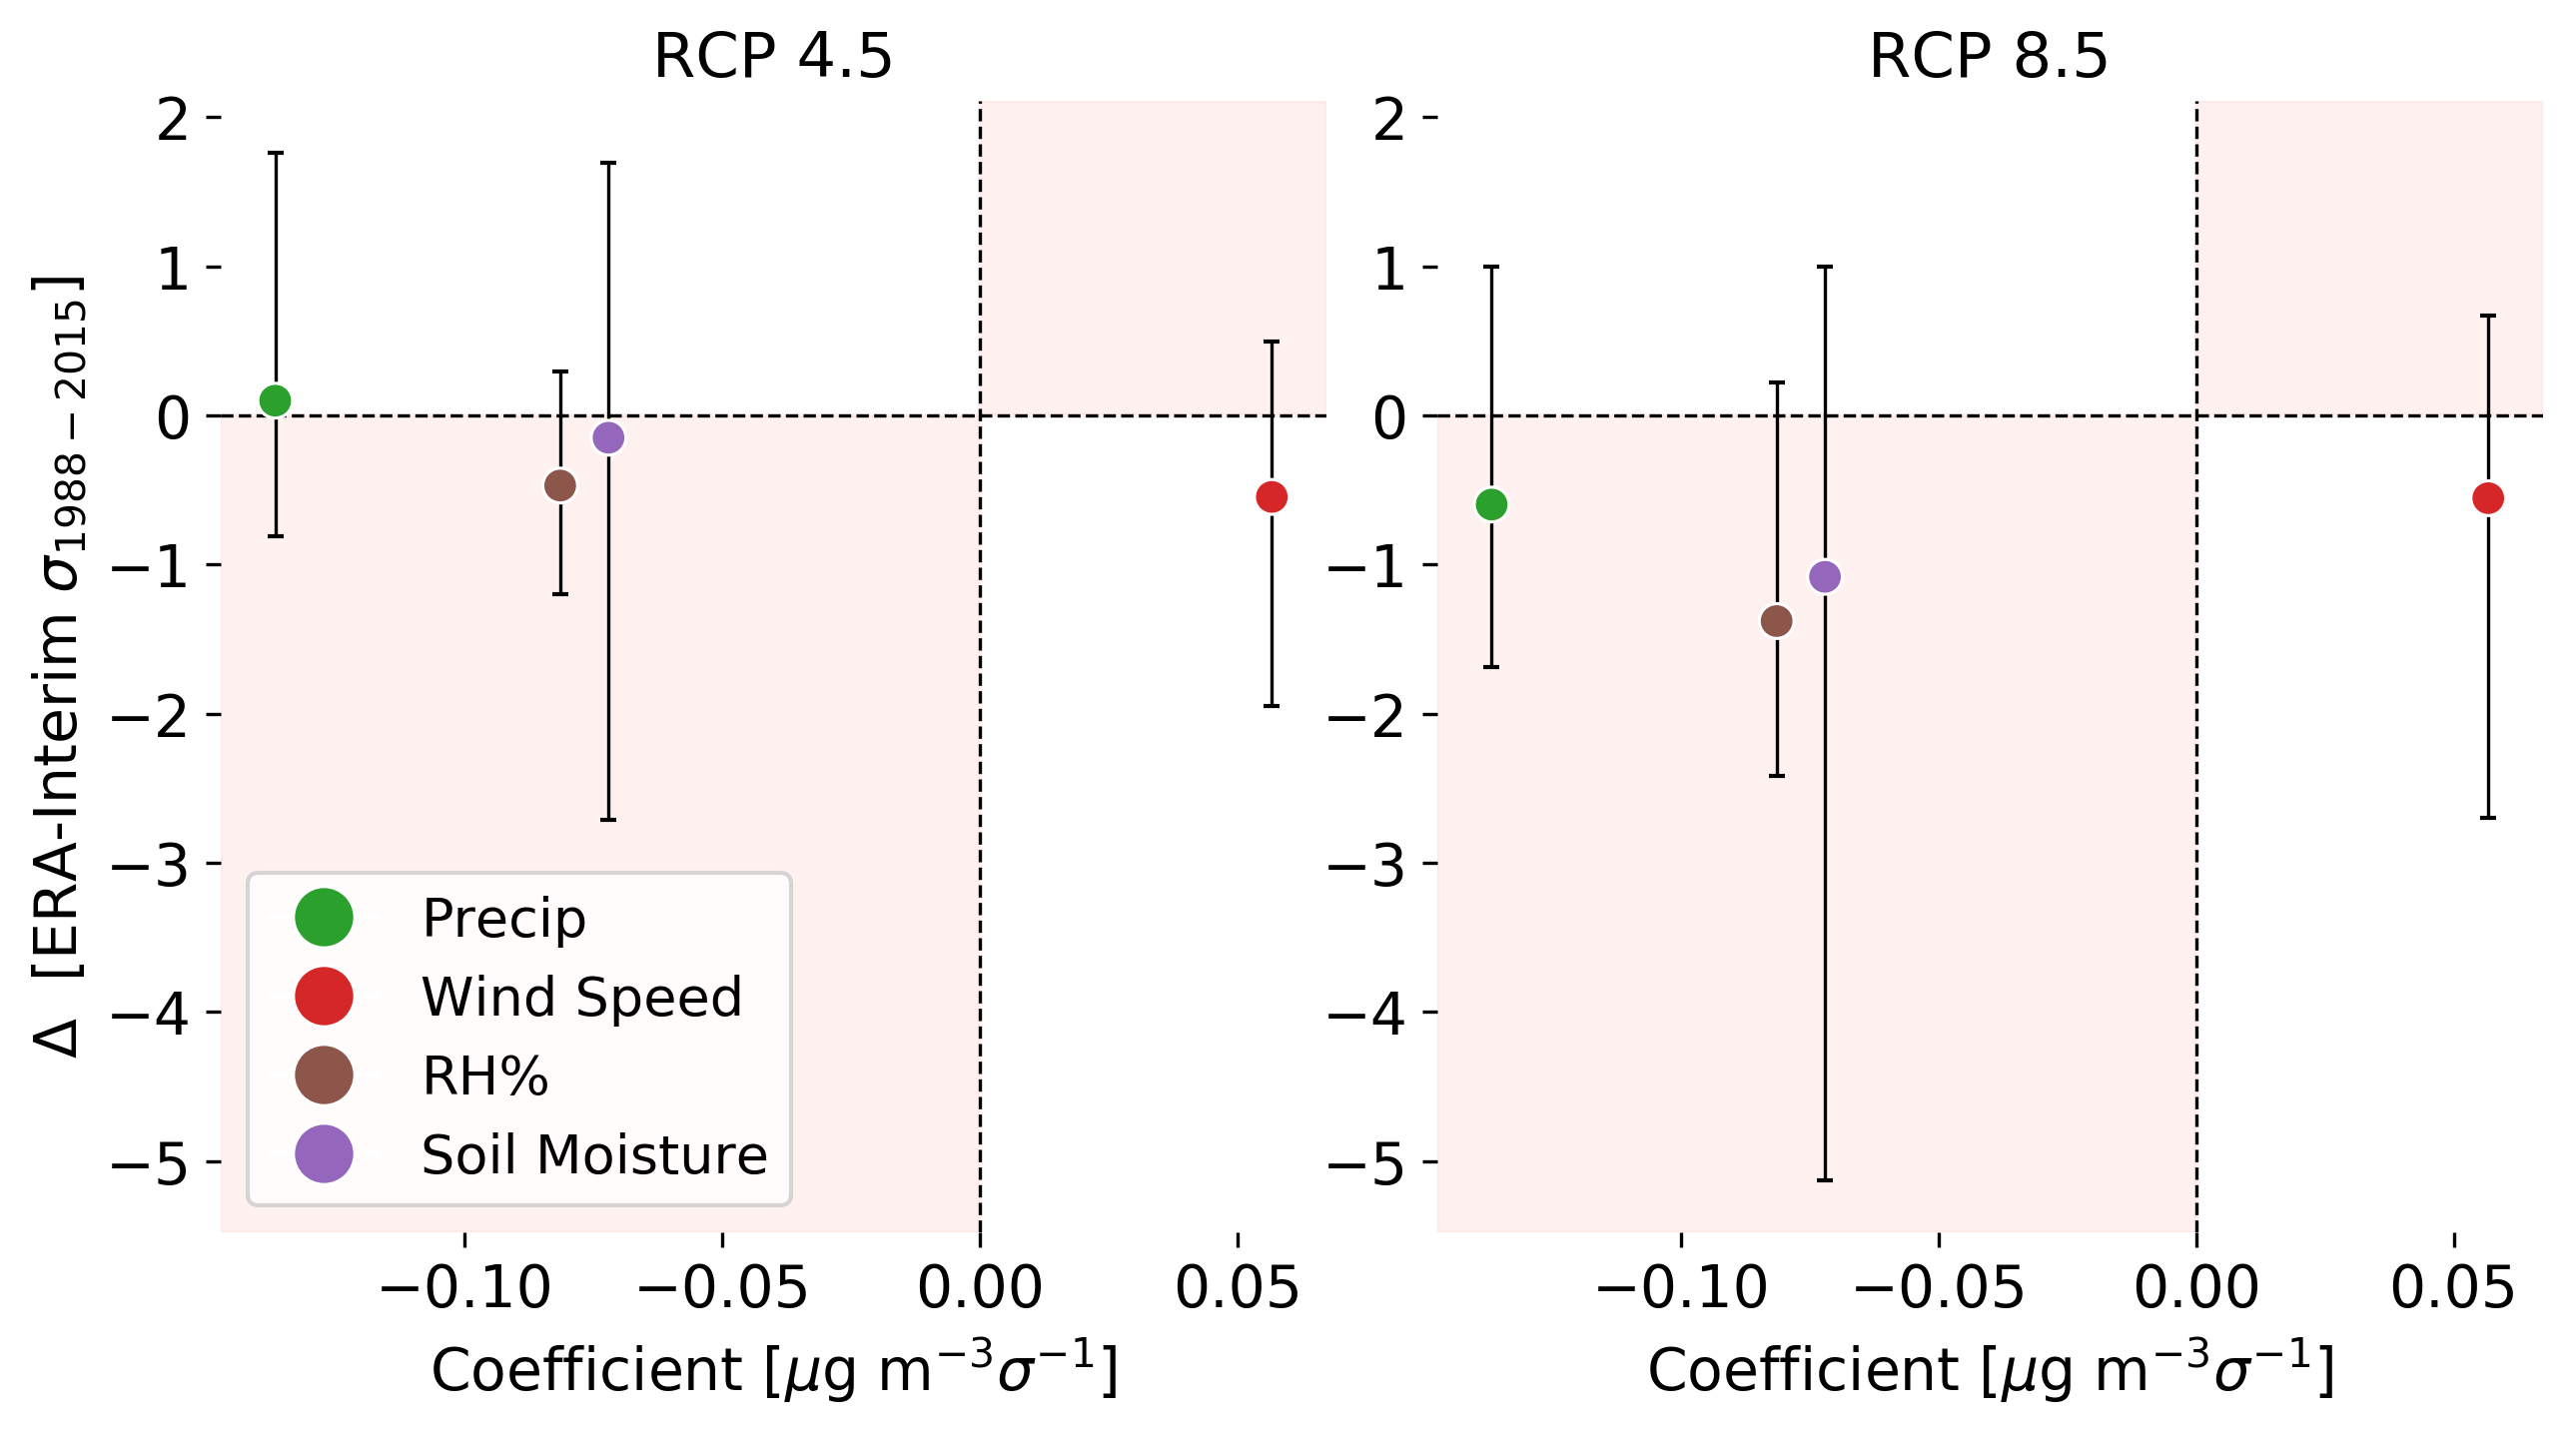

In [27]:
fig = plt.figure(dpi=300, figsize=(10,5))
plt.subplot(121)
ax1=plot_coef_vs_std("Southwest", dataDir, "mouse burger", 
                     scatter_df_45_dict["southwest"], 
                     return_fig=True, rcp="4.5", color_dict=color_dict)

plt.subplot(122, sharey=ax1, sharex=ax1)
ax2=plot_coef_vs_std("Southwest", dataDir, "mouse burger", 
                     scatter_df_85_dict["southwest"], 
                     return_fig=True, rcp="8.5", color_dict=color_dict)

# Keep ylabel for only the left 
ax2.yaxis.label.set_visible(False)

# Get/set require parameters for background shading
ymin, ymax = ax1.get_ylim()
xmin, xmax = ax1.get_xlim()
x0 = np.abs(xmin) / (np.abs(xmin)+np.abs(xmax))

tile_alpha = 0.5
tile_z = 0
down_color = "lavender"
up_color = "mistyrose"

# Set up looping through the panels 
axes = [ax1, ax2]

for ax in axes :
    ax.set_autoscale_on(False)
    ax.axhspan(ymin=ymin, ymax=0, xmin=0, xmax=x0, color=up_color, zorder=tile_z, alpha=tile_alpha) # Lower left 
    ax.axhspan(ymin=0, ymax=ymax, xmin=x0, xmax=1, color=up_color, zorder=tile_z, alpha=0.5) # upper right
    # Remove all individual legends 
    ax.legend_.remove()
    ax.tick_params(labelsize=14)
    ax.set_xlabel("Coefficient [$\mu$g m$^{-3}$$\sigma^{-1}$]")
    
plt.subplots_adjust(wspace=0.1)

ax1.legend(handles=feature_legend, loc="best", prop={'size': 13})
# Handle the legend
leg = ax1.get_legend()
# [left, bottom, width, height]
#leg.set_bbox_to_anchor((0.1, 0.5, 1.5, 0.0))
leg.set_frame_on(True)

plt.savefig(os.path.join(dataDir, "coef_scatter_plots", "lasso_all_rcp_scatter_compare.png"), format='png', bbox_inches="tight")
plt.show()

#### Code for how I learned how to make custom legends

````Python 
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='plant',
                          markerfacecolor='g', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='atmos',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r', label='Color Patch')]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=feature_legend, loc='center')

plt.show()

````

# Show these data together, using scatter, boxplots, & swarmplots

In [28]:
def make_delta_mean_df(df, rcp="8.5") :
    """
    
    WRITE A DOCSTRING FOR THIS COME ON! 
    
    Parameters
    ----------
        df : scatter df 
    """
    
    # Column attributes to describe the delta mean (sigma) values 
    value = []
    feature = []
    feature_type = [] 
    coef = []
    models = []
    feature_N = []
    division = []
    
    model_names = df.columns[9:].values
    variables = np.unique(df.index.values)

    #print(model_names)
    #print(variables)
    
    for var in variables :          # loop through features mean change 
        for model in model_names :  # for a given model

            value.append(df.loc[var, model])
            feature.append(var)
            feature_type.append(df.loc[var, "feature_type"])
            coef.append(df.loc[var, "coef"])
            division.append(df.loc[var, "division"])
            models.append(model)
            feature_N.append(df.loc[var, "feature_N"])
            
    coef = np.array(coef)
    sign = np.chararray((len(coef)), unicode=True)
    sign[:] = "- correlation"
    sign[coef > 0] = "+ correlation"
    

    return pd.DataFrame({"delta_mean":value, "feature":feature, 
                         "feature_type":feature_type, "coef":coef, "coef_sign":sign,
                         "division":division, "model":models, "feature_N":feature_N,
                         "rcp":rcp})

#### Create the nessisary dataframe structure 

In [29]:
l85 = [make_delta_mean_df(scatter_df_85_dict['southwest'], "8.5")]
type(l85[0])

pandas.core.frame.DataFrame

In [30]:
df_85_delta_mean = make_delta_mean_df(scatter_df_85_dict['southwest'], "8.5")
df_45_delta_mean = make_delta_mean_df(scatter_df_45_dict['southwest'], "4.5")

In [31]:
print(np.unique(df_85_delta_mean.rcp))
print(np.unique(df_45_delta_mean.rcp))

['8.5']
['4.5']


In [32]:
print(np.unique(df_85_delta_mean.columns.values))
print(np.unique(df_45_delta_mean.columns.values))

['coef' 'coef_sign' 'delta_mean' 'division' 'feature' 'feature_N'
 'feature_type' 'model' 'rcp']
['coef' 'coef_sign' 'delta_mean' 'division' 'feature' 'feature_N'
 'feature_type' 'model' 'rcp']


#### Concat the different RCP deltas to make it easier to show them together. 

In [33]:
df_delta_mean = pd.concat([df_45_delta_mean, df_85_delta_mean])

### Show how the selected features change by the end of the 21st century
- Number of models will be different, and fewer, since al requiured for EVERY estimate

In [34]:
plot_order = np.unique(df_delta_mean.feature)
print(plot_order)

['hurs_dust_season' 'mrlsl.integrated_dust_season' 'pr_dust_season'
 'sfcWind_dust_season']


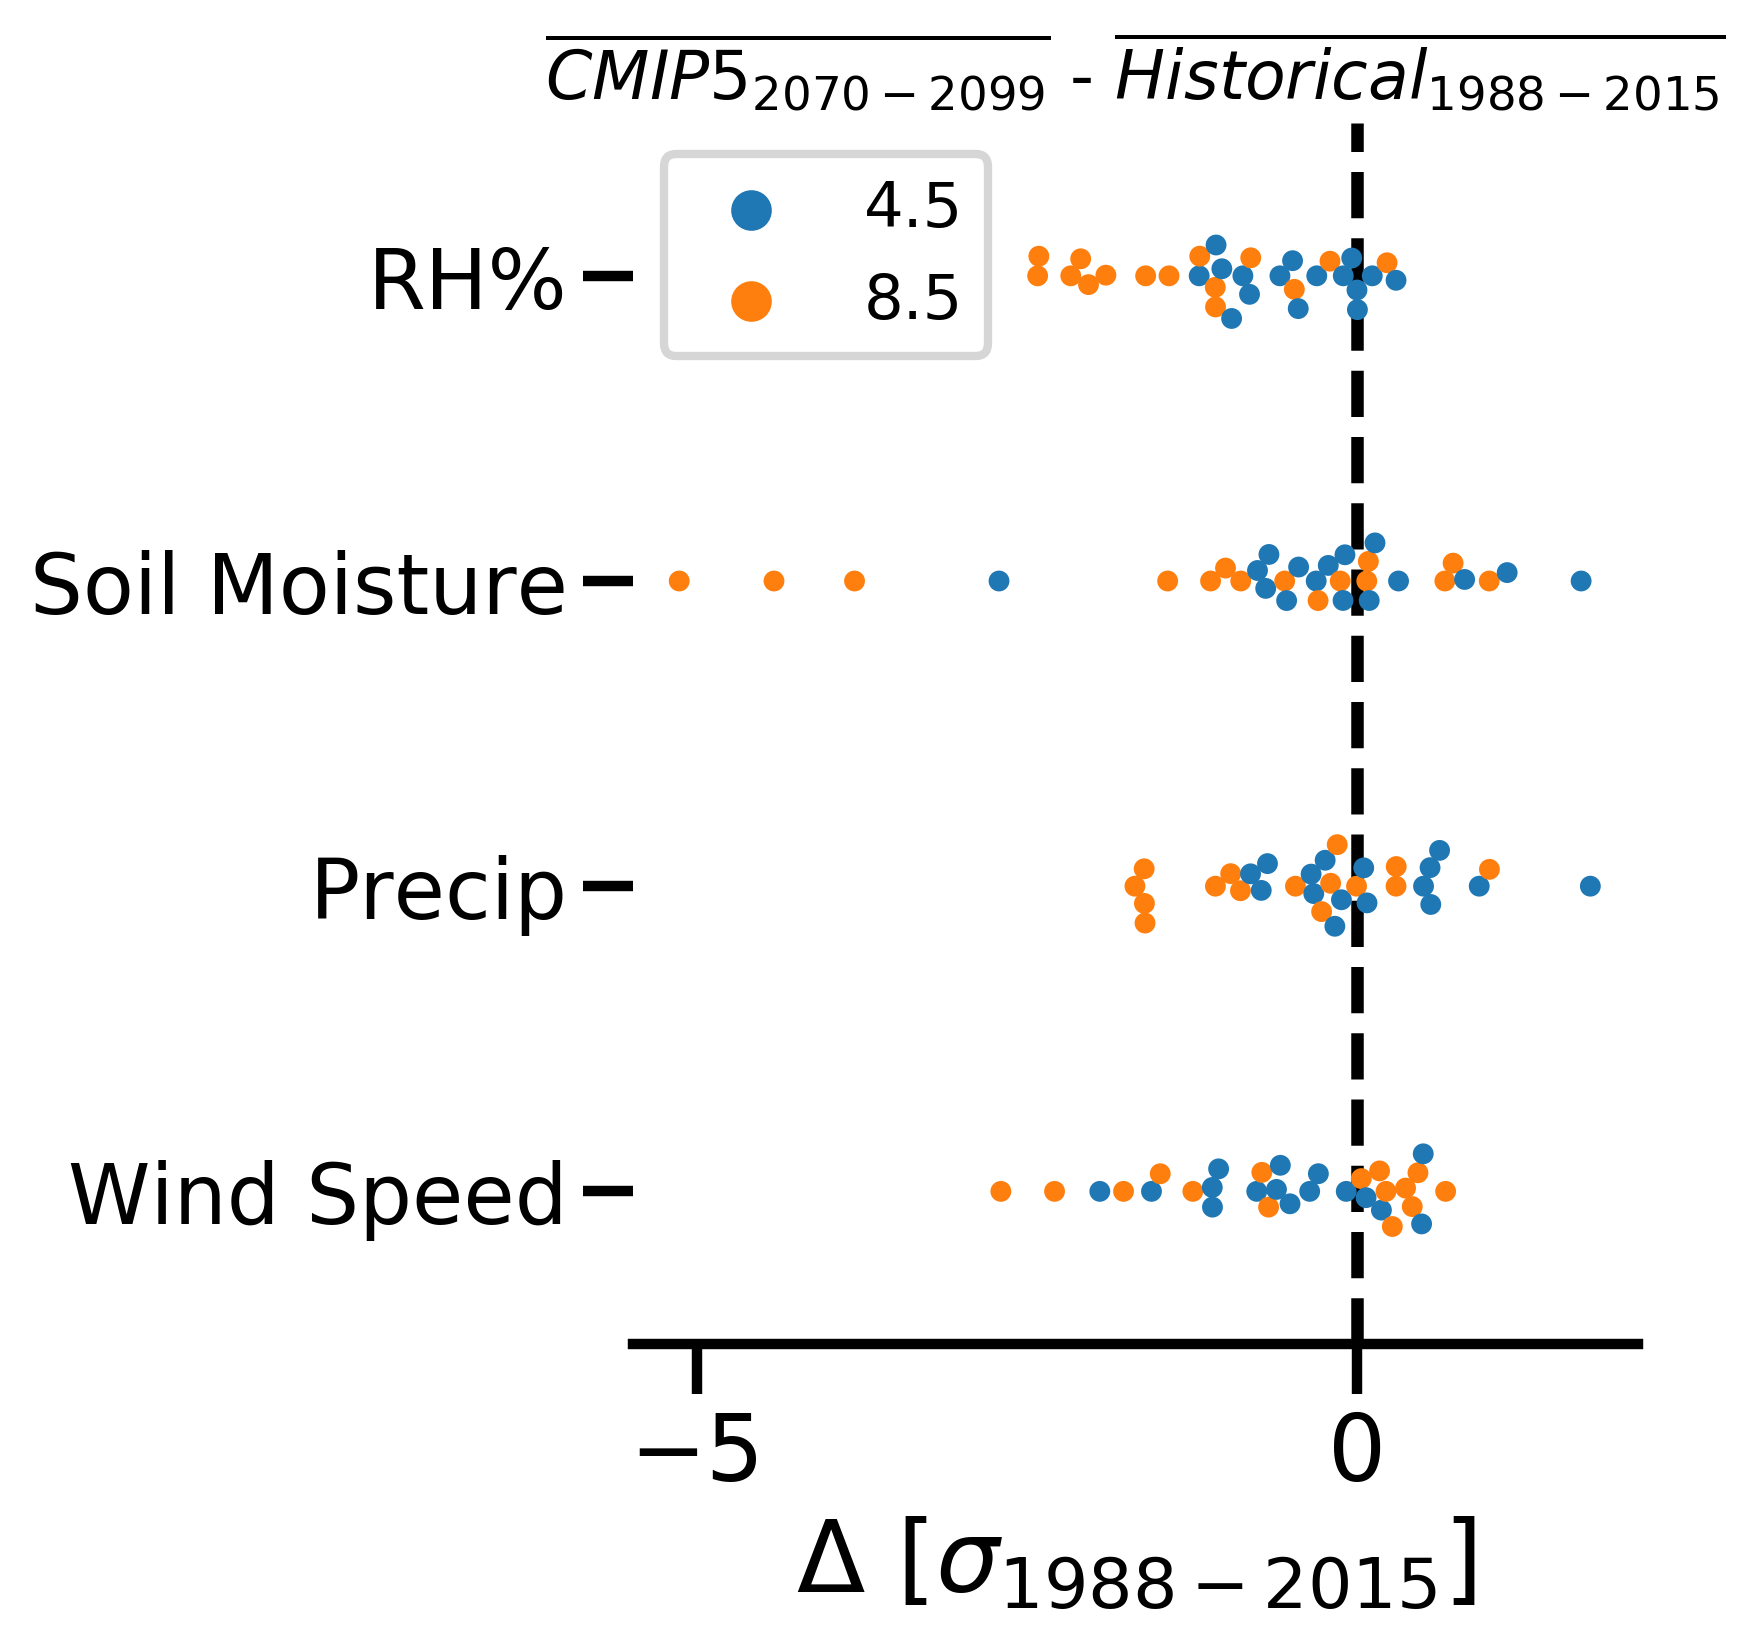

In [35]:
with sns.plotting_context("poster") : 

    yticklabels = ndf.loc[plot_order, "nice_name"]
    
    fig =plt.figure(dpi=300, figsize=(10,6))

    # RCP 4.5 ---------------
    plt.subplot(121)
    ax1 = sns.swarmplot(y="feature", x="delta_mean", hue="rcp",
                        order=plot_order, data=df_delta_mean) 
    
    ax1.spines["left"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    plt.axvline(0, linestyle="--", c="k")
    plt.ylabel("")
    plt.xlabel("$\\Delta$ [$\\sigma_{1988-2015}$]")
    leg1 = plt.legend(prop={'size': 15})
    
    ax1.set_yticklabels(yticklabels, fontsize=20)

    plt.title("$\\overline{CMIP5_{2070-2099}}$ - $\\overline{Historical_{1988-2015}}$", fontsize=16)
        
    plt.tight_layout()

    plt.savefig(os.path.join(dataDir, "lasso_all_CMIP_swamplot.png"))
    plt.show()

### Need a plot that shows the result of the mean change of CMIP5 variable times the coeficient. 
- but also all the individual model results to be transparent about the spread, use the mean values for ranking. 
- This will provide easy explanations of changes in projections that are soon. 

In [36]:
def transform_scatter_dict(df) : 
    """
    Transforms a scatter df and repeats columns by specific model 
    changes in cmip5 model values for different variables. Calculates
    'impact', coef x model_change for a given model, variable, etc. combo. 
    
    Parameters
    ----------
        df: pd.DataFrame, scatter_df, see create_scatter_df() method for
            detials. 
    reuturn
    -------
        pd.DataFrame, with model change information with associated 
        values previosuly independent columns in scatter_df, now 
        those are features in like rows. The goal is to get this
        in good shape to be plotted by seaborn.swarmplot()
    
    """
    
    # New columns. These must all exist in df.columns
    column_names = ["division", "feature", "feature_type", "coef", "model_name", "model_change"]

    k = [i for i,item in enumerate(df.columns.values) if "CMIP5_max" in item][0]
    model_names = df.columns.values[(k+1):]

    d = {} # Fill a dictionary with lists 
    for n in column_names : 
        d[n] = []

    #for div in df.division
    for model in model_names :
        #print(model)
        for i in df.index.values :

            d['model_name'].append( model )
            d['model_change'].append( df.loc[i, model] )
            for n in column_names[:-2] : 
                d[n].append(df.loc[i, n])

    # Estimate impact of each linear coef model change estimate by
    # multiplying the two 
    DF = pd.DataFrame(d)
    DF["impact"] = DF.coef * DF.model_change
                
    return DF

In [37]:
type(scatter_df_85_dict['southwest'])

pandas.core.frame.DataFrame

In [38]:
df_impact_85 = transform_scatter_dict(scatter_df_85_dict["southwest"].copy())
print("df_impact_85.shape", df_impact_85.shape)

df_impact_85.shape (60, 7)


In [39]:
df_impact_45 = transform_scatter_dict(scatter_df_45_dict["southwest"].copy())
print("df_impact_45.shape", df_impact_45.shape)

df_impact_45.shape (64, 7)


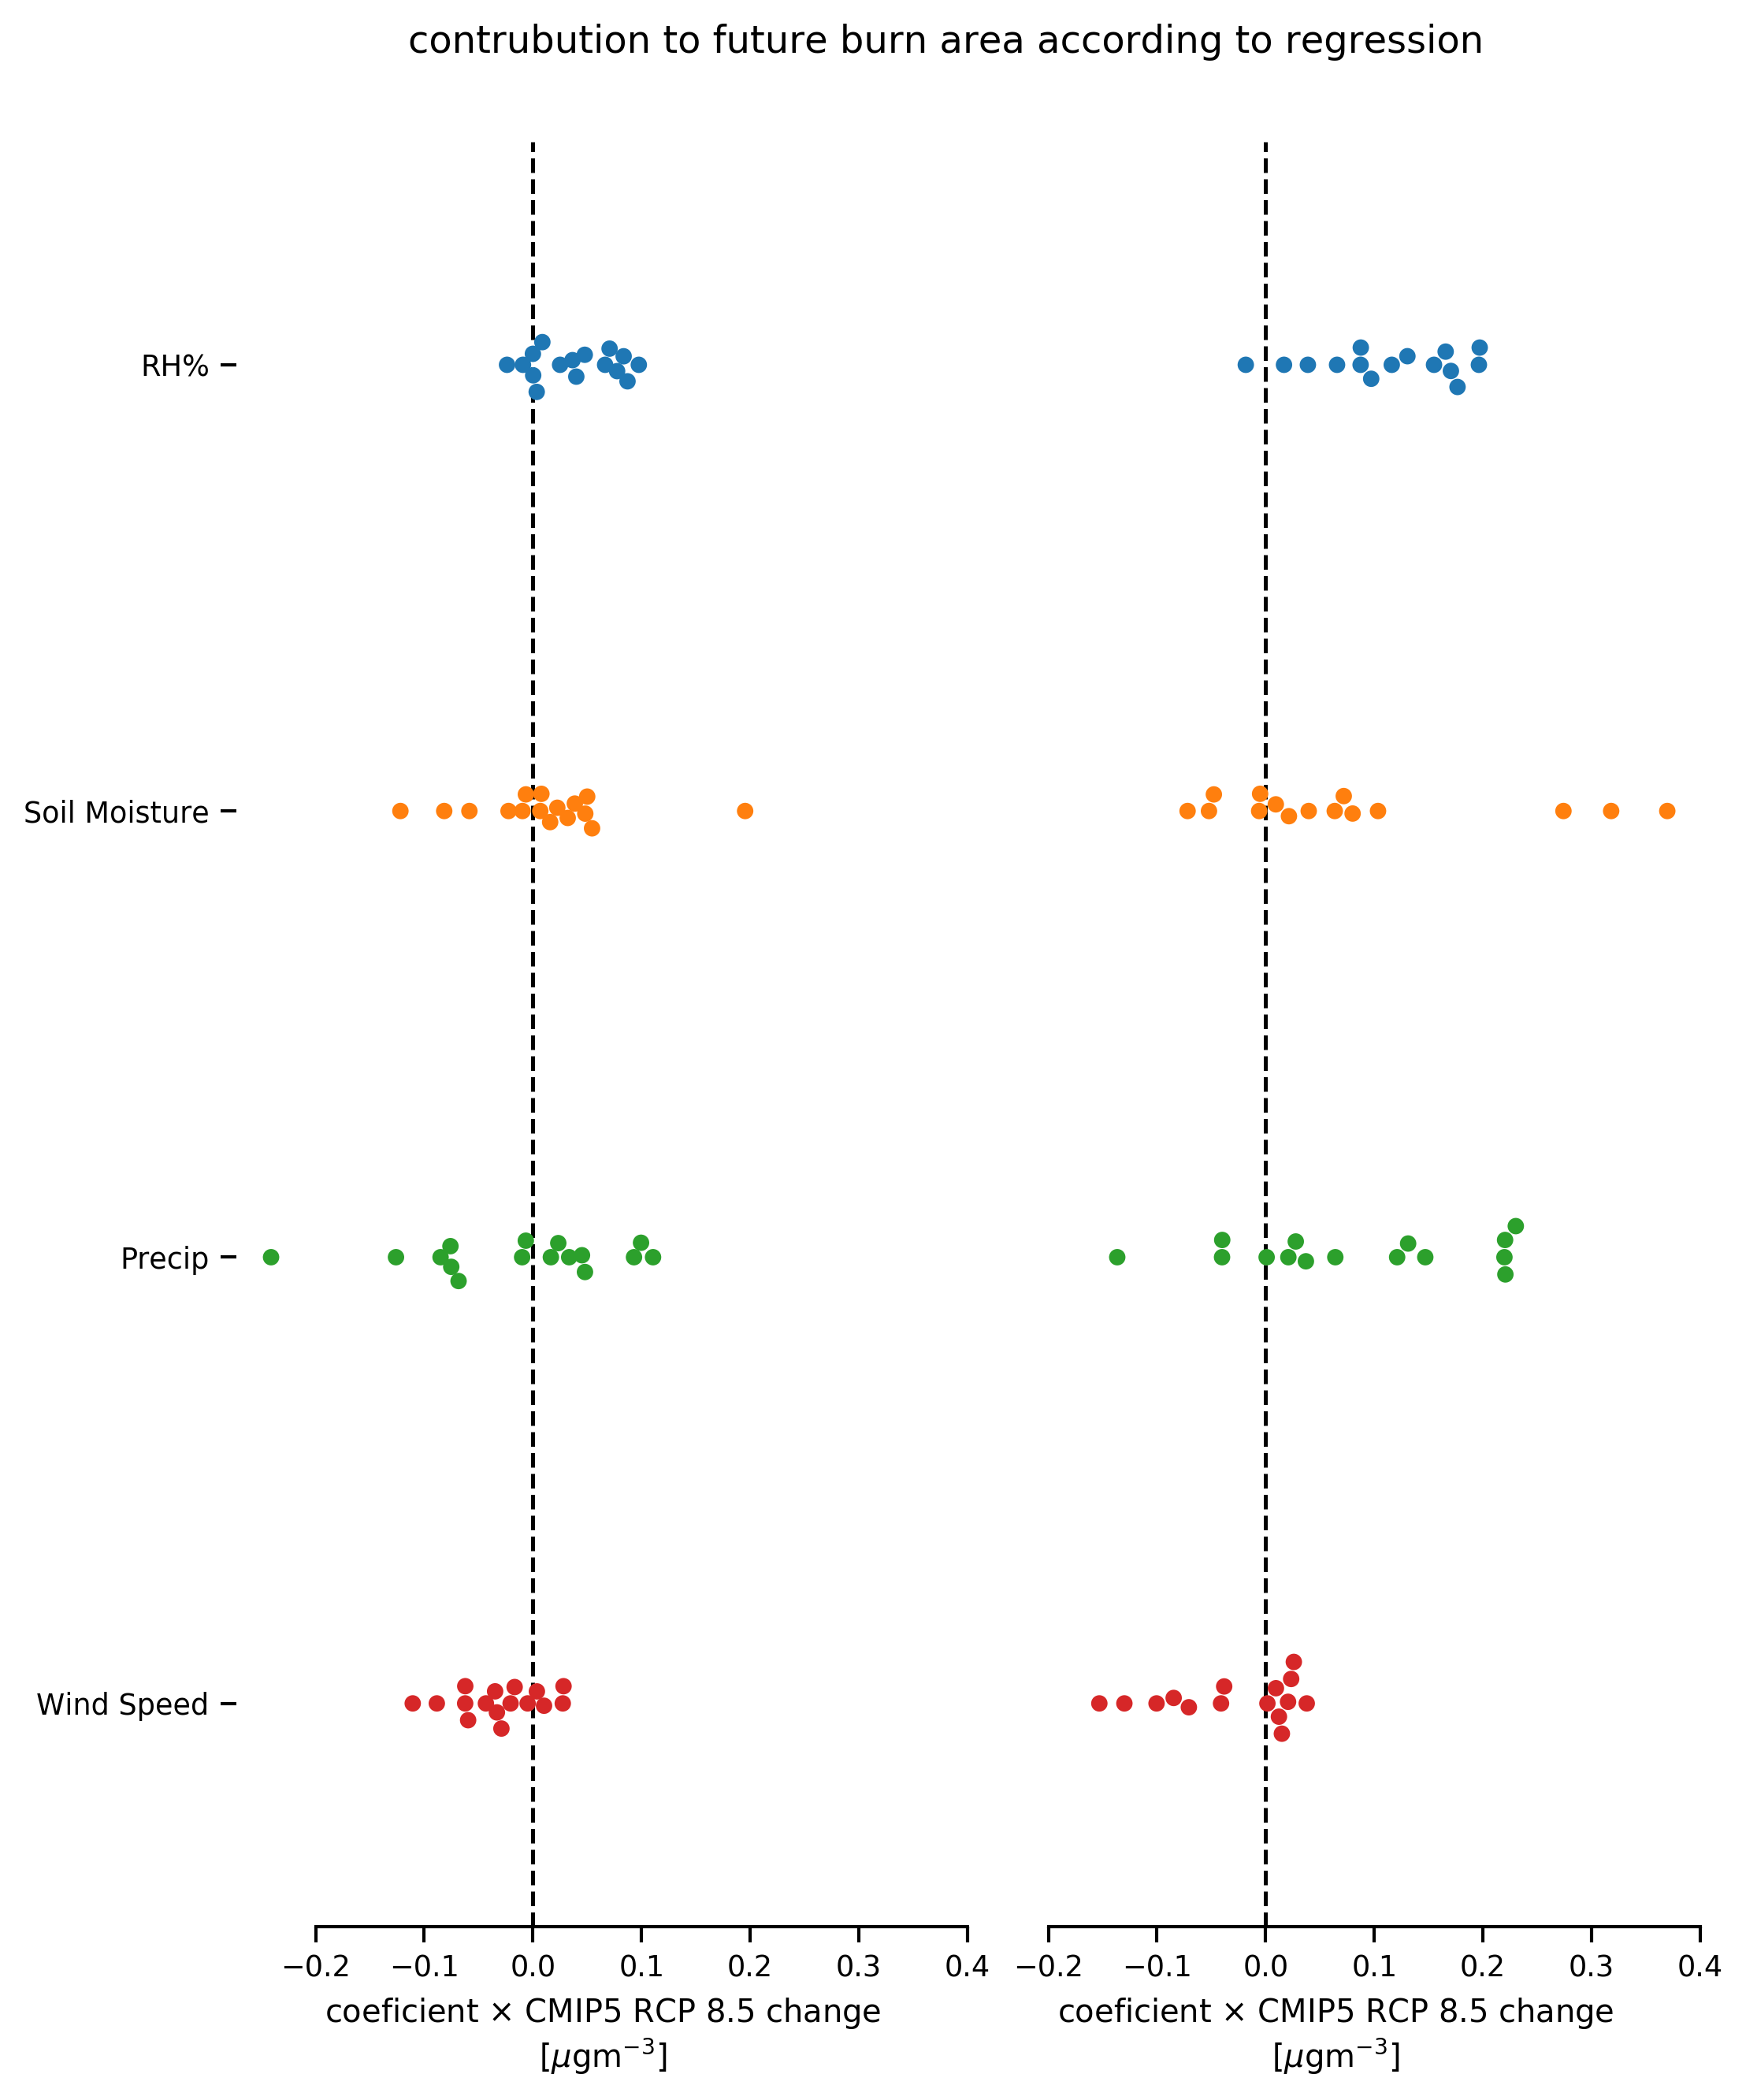

In [40]:
with sns.plotting_context("paper") :

    fig = plt.figure(dpi=300, figsize=(8,10))
    
    yticklabels=ndf.loc[plot_order, "nice_name"]

    plt.subplot(121)
    ax1 = sns.swarmplot(x="impact", y="feature", order=plot_order, data=df_impact_45)
    plt.xlabel("coeficient $\\times$ CMIP5 RCP 8.5 change\n[$\mu$gm$^{-3}$]")
    plt.ylabel("")
    #plt.xticks(rotation=90)
    plt.axvline(0, c="k", linestyle="--")
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.spines["left"].set_visible(False)

    plt.subplot(122, sharex=ax1, sharey=ax1)
    ax2 = sns.swarmplot(x="impact", y="feature", order=plot_order, data=df_impact_85)
    sns.despine(trim=True, left=True)
    plt.xlabel("coeficient $\\times$ CMIP5 RCP 8.5 change\n[$\mu$gm$^{-3}$]")
    plt.ylabel("")
    
    ax2.yaxis.set_visible(False)
    plt.axvline(x=0, linestyle="--", color="k")
        
    ax1.set_yticklabels(yticklabels)
    
    # Reduce the distance between the columns for subplots 
    plt.subplots_adjust(wspace=0.0)

    fig.suptitle("contrubution to future burn area according to regression", y=0.93)
    
    plt.savefig(os.path.join(dataDir, "lasso_all_rcp_85_change_times_coef.png"),  bbox_inches='tight')

    plt.show()

### Burn area visualization 

Here is how the two RCPs can be displayed together! This will be done by adding RCP as an attribute and changing the "col" parameter to "rcp" column of the df_delta_mean.

Possible way to make ranked boxplot needed. 
https://stackoverflow.com/questions/39214484/how-to-rank-plot-in-seaborn-boxplot

#### Handy functions for burn area plots 

In [41]:
dataDir

'../Data/Dust_Analysis/v_2p0_50'

In [42]:
def get_dust_conc_dict(regression_name, rcp) :
    """
    Function for loading pickled dust concentration dictionaries for different
    regressions and scenarios. 
    """
    
    # Get the CMIP5 features expressed in terms of historical variance "Z_dict"
    # or their raw values averaged in a region ""
    f = regression_name + "_dust_conc_rcp" + rcp + '.obj'
    #print("Getting " + f)
    with open(os.path.join(dataDir, f), 'rb') as fp:
        d = pickle.load(fp)
    return d 

def ensemble_stats(BA) :
    """Takes stats across models for each row (year)"""
    return BA.mean(axis=1), BA.min(axis=1), BA.max(axis=1)

def make_arrow_points(y1, y2) :
    """
    y1 : series one to be averaged
    y2 : series two to be average
    
    Returns coordinates to draw arrows illistrating the distance
    betwen the mean of y1 y2 series. 
    """
    
    y1 = np.mean(y1)
    y2 = np.mean(y2)
    
    # TODO: Add functionality to average over specified years 
    delta = np.abs(y1 - y2)
    ymin = np.min([y1 , y2])
    ymax = np.max([y1 , y2])
    
    return delta, ymin, ymax

def get_historic_dust_conc(div) :
    """
    Get historic dust concentrations. Note, the names still say things like burn area
    due to copying of functionality when these codes were used for burn area analysis.
    """
    with open(os.path.join(dataDir, "div_original_burn_area_dict.obj"), 'rb') as fp:
        THINGER = pickle.load(fp)
    return THINGER[div]

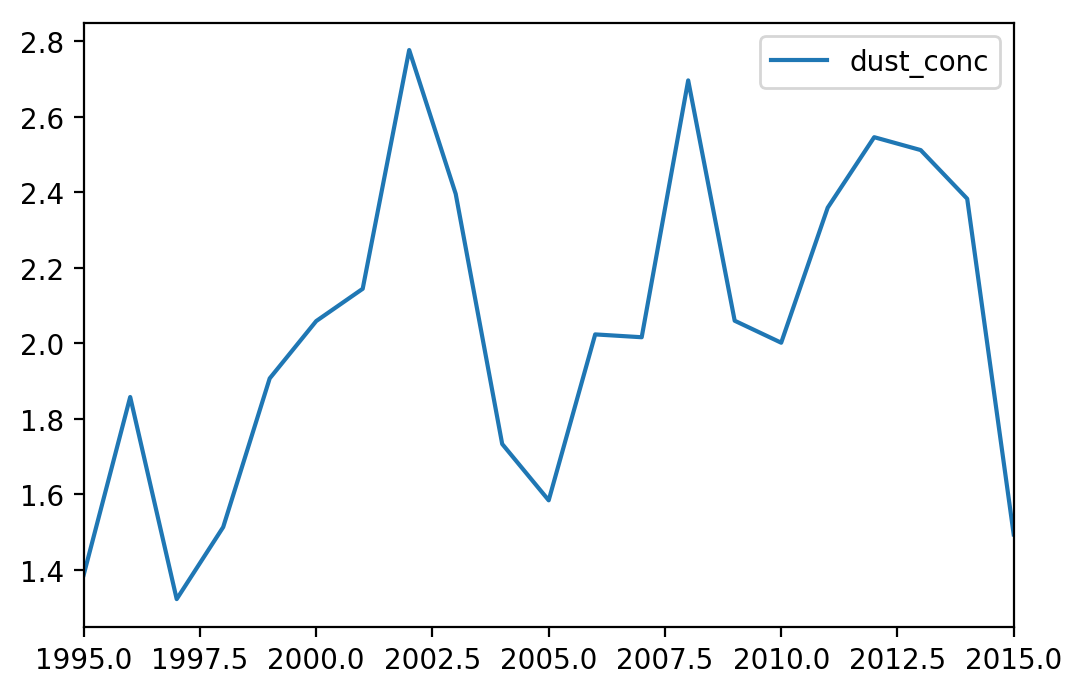

In [43]:
historical_observations = get_historic_dust_conc("southwest")
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
historical_observations.plot(ax=ax)
plt.show()

In [44]:
# https://stackoverflow.com/questions/31671999/python-different-size-subplots-in-matplotlib?rq=1
def dust_projections(div, div_45, div_85, name_1="RCP 4.5", name_2="RCP 8.5") :
    """
    Uses lasso regression estimates of future dust concentrations and plots
    ensemble mean time series for rcp 4.5 and 8.5 as well as the historical
    distribution and the distribution for each RCP for future decades. Make sure
    the dataframes passed for 45 and 85 are already subset along the index to be
    the correct time period for the dust analysis, 1988-onwards. 
    
    # TODO: make all text bigger
    
    Parameters
    ----------
        div: str, name of division to plot 
        div_45: pd.DataFrame with future dust estimates [years x model]
        div_85: pd.DataFrame with future dust estimates [years x model]
        name_1: str, a label for RCP 4.5 data
        name_2: str, a label for RCP 8.5 data
    
    """

    ############################################################
    # Get data needed for plot 
    historical_observations = get_historic_dust_conc(div).values.ravel()
        
    # Calculate the ensemble means! 
    dust_means_45, _, _ = ensemble_stats(div_45)
    dust_means_85, _, _ = ensemble_stats(div_85)

    #with sns.plotting_context("poster") : 
    
    fig=plt.figure(figsize=(10,5), dpi=300)

    gs=GridSpec(2,3) # 2 rows, 3 columns

    ###############################################################
    ax1=fig.add_subplot(gs[0,0:3]) # Time series figure, lines only

    # Plot RCP time series
    plt.plot(dust_means_45, color="C0", linestyle="-", label=name_1)
    plt.plot(dust_means_85, color="C1", linestyle="-", label=name_2)
    plt.axhline(y=np.mean(historical_observations), c="k", linestyle="--", label="1988-2015 mean")
    plt.legend(loc="best")

    # Style components 
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    plt.ylabel("", fontsize=16)
    plt.title( "CMIP5 model southwest dust season estimates", fontsize=20)
    
    ax1.tick_params(axis='both', which='major', labelsize=16)

    #############################################################
    # Historical distributions
    ax3=fig.add_subplot(gs[1,0]) # second row, first column
    plt.xlabel("1995-2015", fontsize=18)

    # Get Models attempt at historical prediction
    history_45 = div_45.loc[1995:2015, :].values.ravel()
    history_85 = div_85.loc[1995:2015, :].values.ravel()

    boxData_history = [historical_observations, history_45, history_85]
    labels  = ["IMPROVE", "4.5", "8.5"]
    colors  = ["purple","C0", "C1"]

    box = plt.boxplot(boxData_history, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)

    plt.axhline(y=np.mean(historical_observations), linestyle="--", c="k")

    # Paint the boxes 
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.ylabel("", fontsize=16)
    
    ax3.tick_params(axis='both', which='major', labelsize=16)
    ax3.spines['right'].set_visible(False)    
    ax3.spines['left'].set_visible(False)    
    ax3.spines['top'].set_visible(False)    
    ax3.spines['bottom'].set_visible(False)    

    #############################################################
    # Mid 21-st century distributions, scenario only 
    ax4=fig.add_subplot(gs[1,1], sharey=ax3) # second row, second column
    plt.xlabel("2040-2060", fontsize=18)

    mid_45 = div_45.loc[2040:2060, :].values.ravel()
    mid_85 = div_85.loc[2040:2060, :].values.ravel()

    boxData_mid = [mid_45, mid_85]

    colors = ["C0", "C1"]
    labels = ["4.5", "8.5"]
    box = plt.boxplot(boxData_mid, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)

    plt.axhline(y=np.mean(historical_observations), linestyle="--", c="k")

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax4.tick_params(axis='both', which='major', labelsize=16)
    ax4.spines['right'].set_visible(False)    
    ax4.spines['left'].set_visible(False)    
    ax4.spines['top'].set_visible(False)    
    ax4.spines['bottom'].set_visible(False)    
    ax4.axes.get_yaxis().set_visible(False)

    #############################################################
    # End of 21st century distributions
    ax5=fig.add_subplot(gs[1,2], sharey=ax3) # second row, third column 
    plt.xlabel("2080-2099", fontsize=18)

    end_45 = div_45.loc[2080:2099, :].values.ravel()
    end_85 = div_85.loc[2080:2099, :].values.ravel()

    boxData_end = [end_45, end_85]

    colors = ["C0", "C1"]
    labels = ["4.5", "8.5"]

    box = plt.boxplot(boxData_end, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)
    ax5.tick_params(axis='both', which='major', labelsize=16)

    plt.axhline(y=np.mean(historical_observations), linestyle="--", c="k")

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax5.spines['right'].set_visible(False)    
    ax5.spines['left'].set_visible(False)    
    ax5.spines['top'].set_visible(False)    
    ax5.spines['bottom'].set_visible(False)    
    ax5.axes.get_yaxis().set_visible(False)

    fig.text(0.02, 0.5, 'Fine dust [$\mu$g m$^{-3}$]', ha='center', va='center', rotation='vertical', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(left=0.1)
   
    f = os.path.join(dataDir, div.replace("/"," ") + '_dust_conc_projections.png')
    fig.savefig(f)
    plt.close()
    
    return fig, f, boxData_history, boxData_mid, boxData_end

### Get dust concentration estimates 
- **(formorly burn area, legacy names)** 
- load the dictionary for all regression types and RCPs (4 total)
- subset to division of interest
- calculate esemble means

In [45]:
# Get burn area dictionary (keys are divisions)
lasso_all_BA_45 = get_dust_conc_dict("lasso_all", "45")
lasso_all_BA_85 = get_dust_conc_dict("lasso_all", "85")

In [46]:
print("n models for RCP 45 estimates",lasso_all_BA_45["southwest"].shape[1])
print("n models for RCP 85 estimates",lasso_all_BA_85["southwest"].shape[1])

n models for RCP 45 estimates 16
n models for RCP 85 estimates 15


In [47]:
div = "southwest"
row1, f1, box_hist, box_mid, box_end = dust_projections(div, lasso_all_BA_45[div].loc[1995:2099], lasso_all_BA_85[div].loc[1995:2099])

### See if end of century values are "statistically different" from the historical period. 

In [48]:
from scipy import stats

In [49]:
# box_hist = [historical_observations, history_45, history_85]
hist_obs = box_hist[0]
rcp_45_hist = box_hist[1]
rcp_85_hist = box_hist[2]

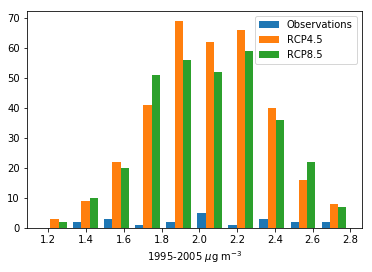

In [50]:
fig=plt.figure()
plt.hist(box_hist, label=["Observations", "RCP4.5", "RCP8.5"])
plt.legend()
plt.xlabel("1995-2005 $\mu$g m$^{-3}$")
plt.show()

In [51]:
print("historical years shape", hist_obs.shape)
print("historical years mean", hist_obs.mean())
print("historical years std", hist_obs.std())

historical years shape (21,)
historical years mean 2.0365576935217877
historical years std 0.418768051670563


In [52]:
print("RCP 8.5 hist years shape ",rcp_85_hist.shape)
print("RCP 8.5 hist years mean ",rcp_85_hist.mean())
print("RCP 8.5 hist years std ",rcp_85_hist.std())

RCP 8.5 hist years shape  (315,)
RCP 8.5 hist years mean  2.0365576935217877
RCP 8.5 hist years std  0.3110392524747


In [53]:
print("RCP 4.5 hist years shape ",rcp_45_hist.shape)
print("RCP 4.5 hist years mean ",rcp_45_hist.mean())
print("RCP 4.5 hist years std ",rcp_45_hist.std())

RCP 4.5 hist years shape  (336,)
RCP 4.5 hist years mean  2.036557693521788
RCP 4.5 hist years std  0.30707117332794215


In [54]:
rcp_85_end = box_end[1]
print("RCP 8.5 end years shape ",rcp_85_end.shape)
print("RCP 8.5 end years mean ",rcp_85_end.mean())
print("RCP 8.5 end years std ",rcp_85_end.std())

RCP 8.5 end years shape  (300,)
RCP 8.5 end years mean  2.2764963130007216
RCP 8.5 end years std  0.4219936424111538


In [55]:
rcp_45_end = box_end[0]
print("RCP 4.5 end years shape ", rcp_45_end.shape)
print("RCP 4.5 end years mean ", rcp_45_end.mean())
print("RCP 4.5 end years std ", rcp_45_end.std())

RCP 4.5 end years shape  (320,)
RCP 4.5 end years mean  2.0577850126383295
RCP 4.5 end years std  0.3454617240311798


#### Test  if the mean of the end of century values for RCP 8.5 are different from the beginning:
- must compare model estimated values in beginning and end

In [56]:
print("Is the difference for RCP8.5 significant?", rcp_85_end.mean() - rcp_85_hist.mean())
stats.ttest_ind(rcp_85_hist, rcp_85_end, equal_var = True)

Is the difference for RCP8.5 significant? 0.2399386194789339


Ttest_indResult(statistic=-8.039553121135883, pvalue=4.6598245082652326e-15)

In [57]:
print("Is the difference for RCP4.5 significant?", rcp_45_end.mean() - rcp_45_hist.mean())
stats.ttest_ind(rcp_45_hist, rcp_45_end, equal_var = False)

Is the difference for RCP4.5 significant? 0.0212273191165413


Ttest_indResult(statistic=-0.8290471515924611, pvalue=0.40738851426680334)